# Scale-Free Networks

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 4

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Facebook data

In [3]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

In [4]:
# https://snap.stanford.edu/data/egonets-Facebook.html 
# https://snap.stanford.edu/data/facebook_combined.txt.gz

fb = read_graph('facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

In [5]:
min(fb.nodes()), max(fb.nodes())

(0, 4038)

In [77]:
from thinkcomplexity import all_pairs

def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / total

In [78]:
def clustering_coefficient(G):
    cc = np.mean([node_clustering(G, node) for node in G])
    return cc

In [79]:
#from thinkcomplexity import clustering_coefficient
C = clustering_coefficient(fb)
C

0.606

In [73]:
nx.average_clustering(fb)

0.606

In [8]:
from thinkcomplexity import path_lengths
from thinkcomplexity import characteristic_path_length

In [9]:
%time pls = path_lengths(fb)

CPU times: user 1min 18s, sys: 568 ms, total: 1min 19s
Wall time: 1min 18s


In [10]:
L = np.mean(pls)
L

3.693

In [11]:
np.max(pls)

8

In [12]:
np.percentile(pls, 90)

5.000

## WS Graph

In [13]:
k = int(round(2*m/n))
k

44

In [14]:
lattice = nx.watts_strogatz_graph(n, k, 0)
len(lattice), len(lattice.edges())

(4039, 88858)

In [15]:
C, clustering_coefficient(lattice)

(0.624, 0.733)

In [16]:
L, characteristic_path_length(lattice)

(3.693, 46.387)

In [17]:
random = nx.watts_strogatz_graph(n, k, 1)

In [18]:
C, clustering_coefficient(random)

(0.624, 0.011)

In [19]:
L, characteristic_path_length(random)

(3.693, 2.603)

In [80]:
ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)

In [81]:
C, clustering_coefficient(ws)

(0.606, 0.630)

In [82]:
L, characteristic_path_length(ws)

(3.693, 3.225)

**Exercise:** Fiddle with $p$ and see if you can do better.

## Degree

In [23]:
def degrees(G):
    return [G.degree(u) for u in G]

In [24]:
np.mean(degrees(fb))

43.691

In [25]:
np.mean(degrees(ws))

44.000

In [26]:
np.std(degrees(fb))

52.414

In [27]:
np.std(degrees(ws))

1.465

In [28]:
from thinkstats2 import Pmf

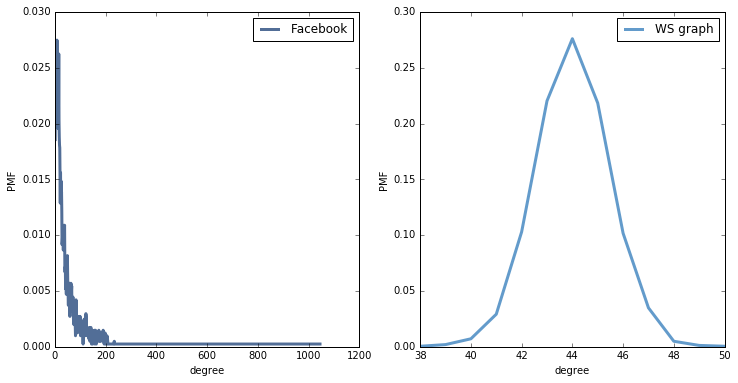

In [29]:
thinkplot.preplot(cols=2)

pmf_fb = Pmf(degrees(fb))
thinkplot.Pdf(pmf_fb, label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')

thinkplot.subplot(2)

pmf_ws = Pmf(degrees(ws))
thinkplot.Pdf(pmf_ws, label='WS graph')
thinkplot.config(xlabel='degree', ylabel='PMF')

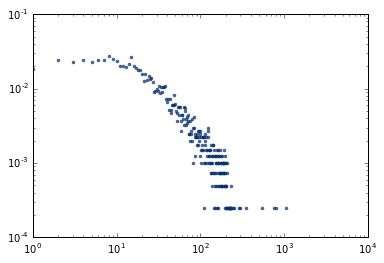

In [30]:
pmf_fb = Pmf(degrees(fb))
thinkplot.Pdf(pmf_fb, style='.')
thinkplot.config(xscale='log', yscale='log')

In [31]:
from thinkstats2 import Cdf

{'xscale': 'linear', 'yscale': 'linear'}

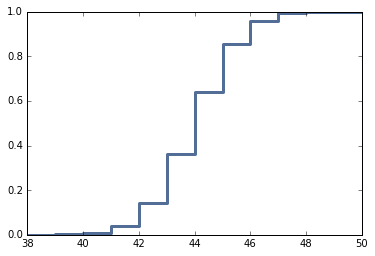

In [32]:
cdf_ws = Cdf(degrees(ws))
thinkplot.Cdf(cdf_ws)

{'xscale': 'linear', 'yscale': 'linear'}

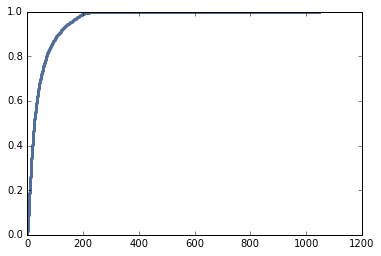

In [33]:
cdf_fb = Cdf(degrees(fb))
thinkplot.Cdf(cdf_fb)

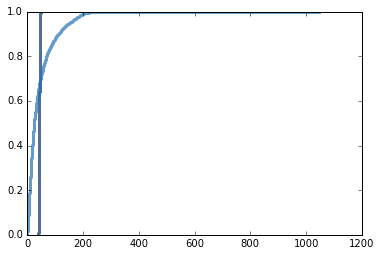

In [34]:
thinkplot.Cdfs([cdf_ws, cdf_fb])

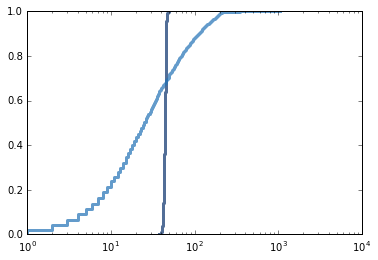

In [35]:
thinkplot.Cdfs([cdf_ws, cdf_fb])
thinkplot.config(xscale='log')

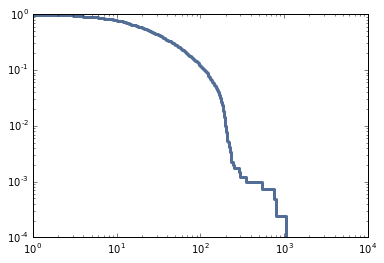

In [36]:
thinkplot.Cdf(cdf_fb, complement=True)
thinkplot.config(xscale='log', yscale='log')

In [37]:
ba = nx.barabasi_albert_graph(n, k//2, seed=15)

In [38]:
len(ba), len(ba.edges())

(4039, 88374)

In [39]:
C, clustering_coefficient(ba)

(0.624, 0.037)

In [40]:
L, characteristic_path_length(ba)

(3.693, 2.511)

In [41]:
np.mean(degrees(ba))

43.760

In [42]:
np.std(degrees(ba))

40.887

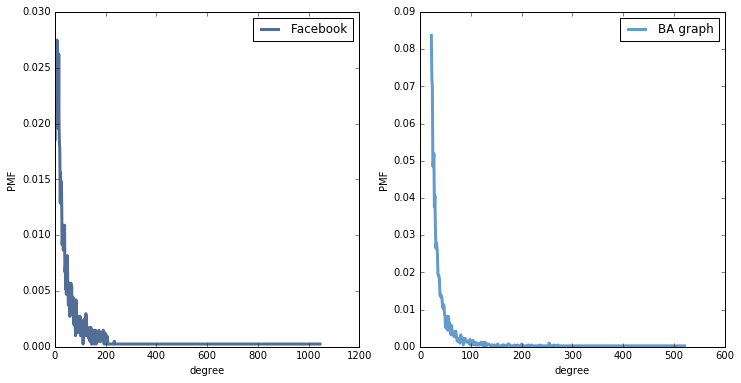

In [43]:
thinkplot.preplot(cols=2)

pmf_fb = Pmf(degrees(fb))
thinkplot.Pdf(pmf_fb, label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')

thinkplot.subplot(2)

pmf_ba = Pmf(degrees(ba))
thinkplot.Pdf(pmf_ba, label='BA graph')
thinkplot.config(xlabel='degree', ylabel='PMF')

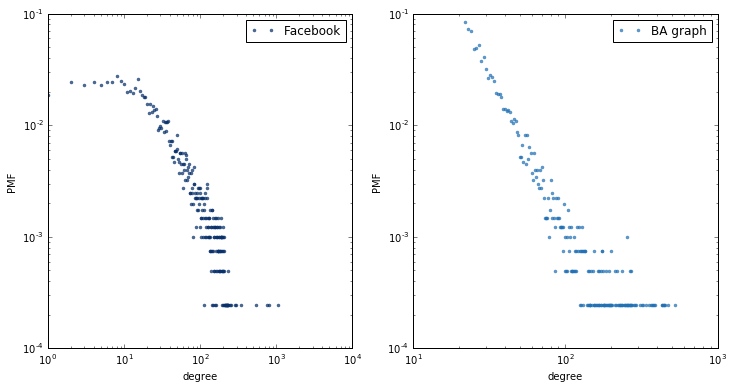

In [44]:
thinkplot.preplot(cols=2)

pmf_fb = Pmf(degrees(fb))
thinkplot.Pdf(pmf_fb, style='.', label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')
thinkplot.config(xscale='log', yscale='log')

thinkplot.subplot(2)

pmf_ba = Pmf(degrees(ba))
thinkplot.Pdf(pmf_ba, style='.', label='BA graph')
thinkplot.config(xlabel='degree', ylabel='PMF')
thinkplot.config(xscale='log', yscale='log')

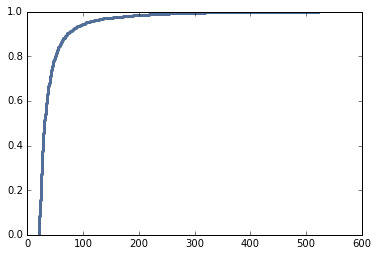

In [45]:
cdf_ba = Cdf(degrees(ba))
thinkplot.Cdf(cdf_ba);

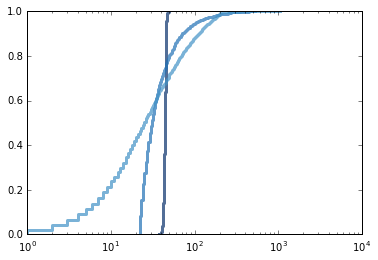

In [46]:
thinkplot.Cdfs([cdf_ws, cdf_ba, cdf_fb])
thinkplot.config(xscale='log')

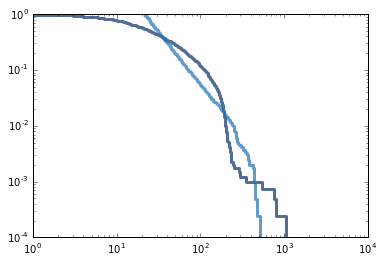

In [47]:
thinkplot.Cdfs([cdf_fb, cdf_ba], complement=True)
thinkplot.config(xscale='log', yscale='log')

## Barabasi-Albert

https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py

In [48]:
import random

def _random_subset(seq,m):
    """ Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.
    """
    targets=set()
    while len(targets)<m:
        x=random.choice(seq)
        targets.add(x)
    return targets

In [49]:
def barabasi_albert_graph(n, m, seed=None):
    """Return random graph using Barabási-Albert preferential attachment model.

    A graph of n nodes is grown by attaching new nodes each with m
    edges that are preferentially attached to existing nodes with high
    degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).

    Returns
    -------
    G : Graph

    Notes
    -----
    The initialization is a graph with with m nodes and no edges.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or  m >=n:
        raise nx.NetworkXError(\
              "Barabási-Albert network must have m>=1 and m<n, m=%d,n=%d"%(m,n))
    if seed is not None:
        random.seed(seed)

    # Add m initial nodes (m0 in barabasi-speak)
    G=nx.empty_graph(m)
    G.name="barabasi_albert_graph(%s,%s)"%(n,m)
    # Target nodes for new edges
    targets=list(range(m))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes=[]
    # Start adding the other n-m nodes. The first node is m.
    source=m
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source]*m,targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source]*m)
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        targets = _random_subset(repeated_nodes,m)
        source += 1
    return G

The characteristic path length is the mean path length for all pairs.

In [50]:
ba1 = nx.barabasi_albert_graph(n, k//2, seed=15)

On a complete graph, the average path length should be 1

In [51]:
ba2 = barabasi_albert_graph(n, k//2, seed=15)

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [52]:
ba1.edges() == ba2.edges()

True

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

## Exercises

**Exercise:** powerlaw_cluster_graph

In [53]:
m = k//2
hk = nx.powerlaw_cluster_graph(n, m, 1.0, seed=15)
len(hk), len(hk.edges())

(4039, 88354)

In [54]:
C, clustering_coefficient(hk)

(0.624, 0.261)

In [55]:
L, characteristic_path_length(hk)

(3.693, 2.781)

In [56]:
np.mean(degrees(hk)), np.std(degrees(hk))

(43.750, 41.495)

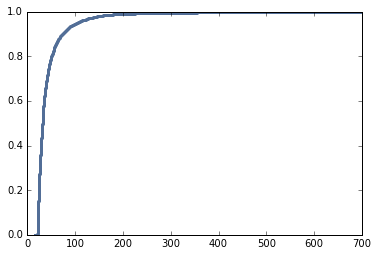

In [57]:
cdf_hk = Cdf(degrees(hk))
thinkplot.Cdf(cdf_hk);

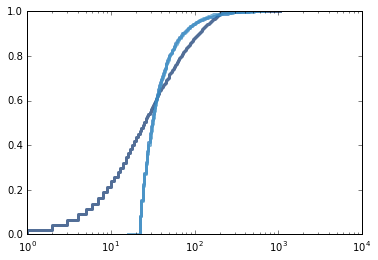

In [58]:
thinkplot.Cdfs([cdf_fb, cdf_ba, cdf_hk])
thinkplot.config(xscale='log')

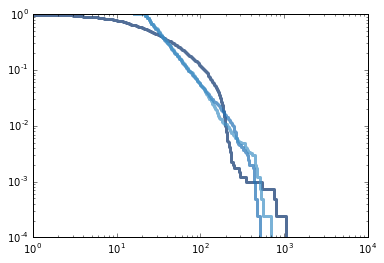

In [59]:
thinkplot.Cdfs([cdf_fb, cdf_ba, cdf_hk], complement=True)
thinkplot.config(xscale='log', yscale='log')

**Exercise:** Downey graph

In [60]:
from random import choice
from thinkcomplexity import flip

In [61]:
def triangle(G, u, v):
    fof = set(G[v])
    if u in G:
        fof -= set(G[u])
    if fof:
        w = choice(list(fof))
        G.add_edge(u, w)
    G.add_edge(u, v)
    
def downey_graph(n, m, p=0.25, seed=None):
    
    if m < 1 or  m >=n:
        raise nx.NetworkXError(\
              "Downey network must have m>=1 and m<n, m=%d,n=%d"%(m,n))
    if seed is not None:
        random.seed(seed)

    G = nx.complete_graph(m+1)
    G.name="downey_graph(%s,%s)"%(n,m)

    for source in range(len(G), n):
        target = choice(G.nodes())
        friends = G.neighbors(target)
        k = len(friends)

        for friend in friends:
            if flip(p):
                triangle(G, source, friend)

        G.add_edge(source, target)
            
    return G

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [62]:
n = len(fb)
m = int(round(np.mean(degrees(fb))))
n, m

(4039, 44)

In [63]:
dg = downey_graph(n, m, p=0.25, seed=21)

In [64]:
len(dg), len(dg.edges())

(4039, 92343)

In [65]:
C, clustering_coefficient(dg)

(0.624, 0.274)

In [66]:
#L, characteristic_path_length(dg)

In [67]:
np.mean(degrees(fb)), np.mean(degrees(dg))

(43.691, 45.726)

In [68]:
np.std(degrees(fb)), np.std(degrees(dg))

(52.414, 60.342)

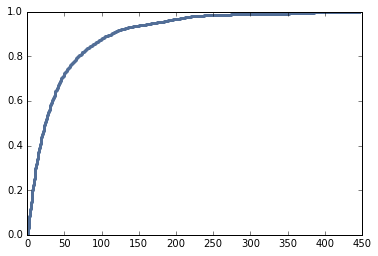

In [69]:
cdf_dg = Cdf(degrees(dg))
thinkplot.Cdf(cdf_dg);

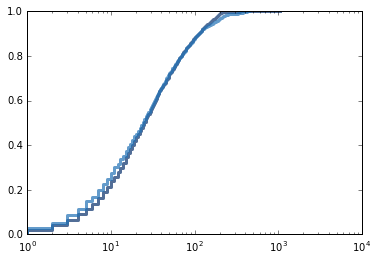

In [70]:
thinkplot.Cdfs([cdf_fb, cdf_dg])
thinkplot.config(xscale='log')

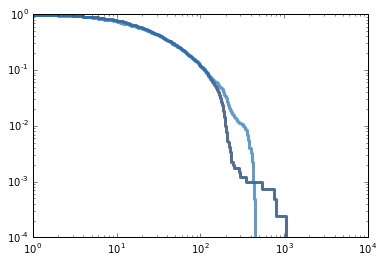

In [71]:
thinkplot.Cdfs([cdf_fb, cdf_dg], complement=True)
thinkplot.config(xscale='log', yscale='log')
